# 文件处理并输出结果

总共找到 1000 个bin文件，开始分批处理，每批 10 个文件


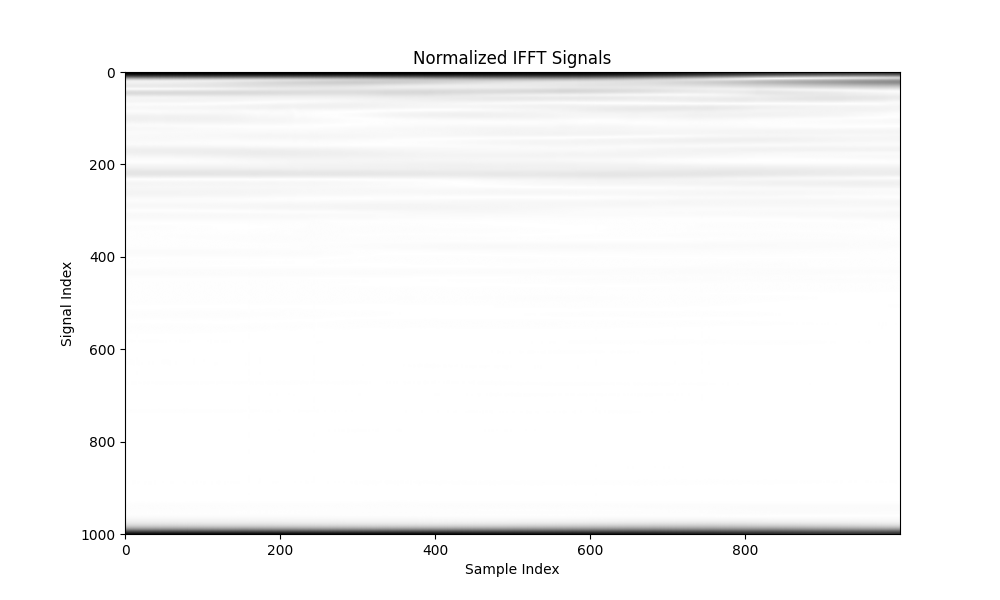

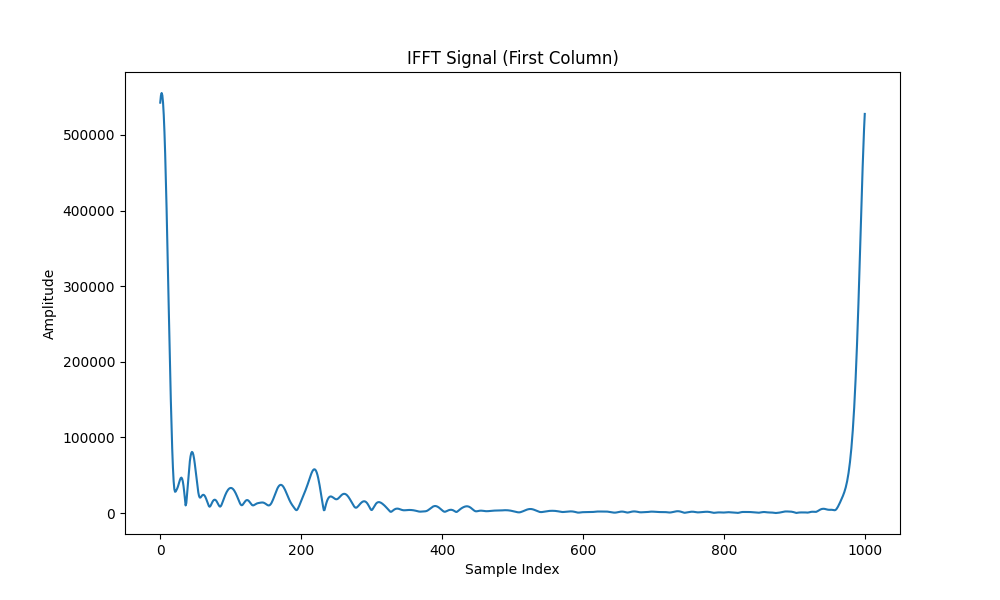

In [14]:
import glob
import os
from scipy.signal import butter, filtfilt, hilbert
from natsort import natsorted  # 导入natsorted进行自然排序
from scipy.signal import butter, filtfilt
from scipy.signal import correlate
from scipy.signal import hilbert
import matplotlib.pyplot as plt
#%matplotlib ipympl

def read_process_and_output(folder_path, match_I_dir, match_Q_dir):
    import numpy as np
    

    def read_bin_data(file_path, mode='wk'):
        """
        读取二进制文件数据，支持两种模式：
        - 'wk'：直接返回 int16 格式的原始数据（单通道）
        - 'pcie'：返回解包后的双通道数据（类似IQ分离）

        参数：
            file_path: 文件路径
            mode: 读取模式 ('wk' 或 'pcie')，默认为 'wk'

        返回：
            若 mode='wk'：返回 np.int16 数组
            若 mode='pcie'：返回 (data1, data2) 两个 np.int16 数组
        """
        with open(file_path, 'rb') as file:
            data = np.fromfile(file, dtype=np.int16)
        
        if mode.lower() == 'pcie':
            # PCIE模式：解包双通道数据（类似MATLAB的奇偶分离）
            length = len(data)
            data1 = data[0:length:2]  # 偶数索引（Python从0开始）
            data2 = data[1:length:2]  # 奇数索引
            return data1, data2
        else:
            # 默认WK模式：返回原始数据
            return data

    #==================数据读取改进的部分==============================
    def process_all_bin_files_batchwise(folder_path, mode='wk', batch_size=10):
        """
        分批读取bin文件，避免MemoryError。

        每batch_size个文件构成一个矩阵，最后按行拼接所有batch。

        参数：
            folder_path: bin文件夹路径
            mode: 'wk' 或 'pcie'
            batch_size: 每次处理的文件数量，默认10

        返回：
            mode='wk': 返回二维矩阵，每行对应一个bin文件内容
            mode='pcie': 返回两个矩阵 data1_matrix, data2_matrix
        """
        bin_files = natsorted(glob.glob(os.path.join(folder_path, '*.bin')))
        print(f"总共找到 {len(bin_files)} 个bin文件，开始分批处理，每批 {batch_size} 个文件")

        data_batches_1 = []
        data_batches_2 = []

        for i in range(0, len(bin_files), batch_size):
            batch_files = bin_files[i:i + batch_size]
            batch_data_1 = []
            batch_data_2 = []

            for file in batch_files:
                if mode.lower() == 'pcie':
                    d1, d2 = read_bin_data(file, mode='pcie')
                    batch_data_1.append(d1)
                    batch_data_2.append(d2)
                else:
                    d = read_bin_data(file, mode='wk')
                    batch_data_1.append(d)

            # 将当前batch拼接成矩阵并保存
            data_batches_1.append(np.vstack(batch_data_1))
            if mode.lower() == 'pcie':
                data_batches_2.append(np.vstack(batch_data_2))

        # 最终拼接所有批次
        all_data1 = np.concatenate(data_batches_1, axis=0)
        if mode.lower() == 'pcie':
            all_data2 = np.concatenate(data_batches_2, axis=0)
            return all_data1, all_data2
        else:
            return all_data1

    #==================数据切片部分==============================
    def slice_and_trim_data(data_list, slice_size, slice_start, slice_end):
        result = []

        for i in range(0, len(data_list), slice_size):
            slice_ = data_list[i:i + slice_size]
            if len(slice_) > 1:
                result.append(slice_[1:])

        result_matrix = np.array(result)

        result_matrix = result_matrix[:, slice_start:slice_end]
        return result_matrix

    def step_slice(matrix, start=0, step=1500):
        # 计算需要的行数
        num_slices = (matrix.size - start) // step
        # 初始化一个空列表来保存结果
        result = []
        
        # 进行切片操作
        for i in range(num_slices):
            start_idx = start + i * step
            end_idx = start_idx + step
            if end_idx > matrix.size:
                break
            result.append(matrix[start_idx:end_idx])
        
        # 将结果转换为矩阵
        result_matrix = np.array(result)
        
        return result_matrix

    def align_received_signals(processed_data, transmit_signal, slice_length=None):
        """
        根据互相关对齐接收信号与发射信号。
        
        参数:
            processed_data : ndarray, shape (N, L)
                每一行是一个接收信号
            transmit_signal : ndarray, shape (T,)
                发射信号
            slice_length : int or None
                切分长度，如果为 None，则保留从最大相关开始到结尾的部分

        返回:
            aligned_signals : ndarray, shape (N, slice_length)
                与发射信号对齐后的接收信号矩阵
        """
        aligned_signals = []

        for i in range(processed_data.shape[0]):
            received = processed_data[i]
            correlation = correlate(received, transmit_signal, mode='valid')
            best_shift = np.argmax(correlation)  # 最佳匹配的位置
            
            # 从该位置开始切分
            if slice_length is None:
                aligned = received[best_shift:]
            else:
                end_index = best_shift + slice_length
                if end_index > len(received):  # 边界处理
                    aligned = received[best_shift:]
                    # 补0到目标长度
                    aligned = np.pad(aligned, (0, slice_length - len(aligned)))
                else:
                    aligned = received[best_shift:end_index]
            
            aligned_signals.append(aligned)
        
        return np.array(aligned_signals)

    #==================信号处理部分==============================
    def downconvert_and_filter(received_signal, transmit_signal, fs=3e9, low_cutoff=2e6):
        # 步骤1：对每个回波信号进行下变频（与发射信号相乘）
        downconverted_signal = received_signal * transmit_signal

        # 步骤2：设计低通滤波器，保留低频部分
        nyquist = 0.5 * fs  # 奈奎斯特频率
        low = low_cutoff / nyquist  # 截止频率低于信号带宽的一部分
        b, a = butter(4, low, btype='low')  # 4阶低通滤波器

        # 步骤3：使用filtfilt进行零相位滤波
        filtered_signal = filtfilt(b, a, downconverted_signal)

        return filtered_signal

    def hilbert_transform(signal):
        # 应用希尔伯特变换
        analytic_signal = hilbert(signal)
        
        # 提取瞬时幅度和相位
        instantaneous_amplitude = np.abs(analytic_signal)
        instantaneous_phase = np.angle(analytic_signal)
        
        return analytic_signal, instantaneous_amplitude, instantaneous_phase
    def bandpass_filter(data, fs, low_cutoff, high_cutoff, order=4):
        nyquist = 0.5 * fs  # 奈奎斯特频率
        low = low_cutoff / nyquist  # 低截止频率的标准化
        high = high_cutoff / nyquist  # 高截止频率的标准化
        # 使用butter函数设计带通滤波器
        b, a = butter(order, [low, high], btype='band')
        # 使用filtfilt进行零相位滤波
        filtered_data = filtfilt(b, a, data)
        return filtered_data
    
   
    

   
    

    
    
    
    
    




    #==================读取bin文件 形成待处理的信号==============================
    data_array = process_all_bin_files_batchwise(folder_path, mode='wk', batch_size=10)
    slice_raw_data = data_array[:, 8150:192000]
    slice_raw_data = slice_raw_data - np.mean(slice_raw_data, axis=1)[:, np.newaxis]

    #==================读取用于下变频的信号==============================
    loaded_data_array_I = np.load(match_I_dir)
    loaded_data_array_Q = np.load(match_Q_dir)

    #==================带通滤波并显示结果==============================
    # 设置采样率、低高截止频率
    fs = 3e9  # 采样频率：3 GHz
    low_cutoff = 300e6  # 低截止频率：300 MHz
    high_cutoff = 1000e6  # 高截止频率：1000 MHz
    # 对每一行信号进行带通滤波
    filtered_data_bandpass = np.array([bandpass_filter(slice_raw_data[i], fs, low_cutoff, high_cutoff) for i in range(slice_raw_data.shape[0])])
    
    #processed_raw_data = align_received_signals(slice_raw_data, loaded_transmit_data_array, slice_length=150001)

    #==================使用发射信号和接收信号匹配寻找初始位置==============================
    processed_data = align_received_signals(filtered_data_bandpass, loaded_data_array_I, slice_length=150000)

    #==================I路下变频==============================
    # 对每个周期信号进行下变频和低通滤波
    filtered_signals = []
    for i in range(processed_data.shape[0]):
        filtered_signal = downconvert_and_filter(processed_data[i], loaded_data_array_I, fs=1e8,low_cutoff=1e6)
        filtered_signals.append(filtered_signal)
    # 将所有下变频和滤波后的信号转换为numpy数组
    filtered_signals = np.array(filtered_signals)

    #==================Q路下变频==============================
    # 对每个周期信号进行下变频和低通滤波
    filtered_signals_Q = []
    for i in range(processed_data.shape[0]):
        filtered_signal_Q = downconvert_and_filter(processed_data[i], loaded_data_array_Q, fs=1e8,low_cutoff=1e6)
        filtered_signals_Q.append(filtered_signal_Q)
    # 将所有下变频和滤波后的信号转换为numpy数组
    filtered_signals_Q = np.array(filtered_signals_Q)

    #==================频率点切分==============================
    import numpy as np

    num_rows = filtered_signals.shape[0]
    segment_len = 1500
    slice_start = 1100
    slice_end = 1200
    num_segments = filtered_signals.shape[1] // segment_len
    slice_width = slice_end - slice_start
    # 创建结果数组用于存储均值
    averaged_part = np.zeros((num_rows, num_segments), dtype=np.float32)
    averaged_part_Q = np.zeros_like(averaged_part)
    # 逐行逐段提取1100:1200并求平均
    for i in range(num_rows):
        row_I = filtered_signals[i]
        row_Q = filtered_signals_Q[i]

        for seg in range(num_segments):
            start = seg * segment_len + slice_start
            end = seg * segment_len + slice_end

            segment_I = row_I[start:end]
            segment_Q = row_Q[start:end]

            averaged_part[i, seg] = np.mean(segment_I)
            averaged_part_Q[i, seg] = np.mean(segment_Q)
    # 构建复信号
    complex_result = averaged_part - 1j * averaged_part_Q

    #==================信号加窗==============================
    # 加窗：对每行信号乘以 Hamming 窗（长度为100）
    hamming_window = np.hamming(complex_result.shape[1])  # shape: (100,)
    windowed_part = complex_result * hamming_window  # shape: (21, 100)
    # 补零：将 100 维信号补零到 1000 维
    padded_part = np.pad(windowed_part, ((0, 0), (0, 900)), mode='constant')  # shape: (21, 1000)
    # 对每个信号进行 IFFT 操作
    ifft_signals = np.fft.ifft(padded_part, axis=1)  # shape: (21, 1000)
    # 转置为 (1000, 21)，以便后续画图或进一步处理
    ifft_signals = ifft_signals.T  # shape: (1000, 21)


    #==================绘制结果==============================
    #绘制A-Scan
    fig_ascan = plt.figure(figsize=(10, 6))
    plt.plot(np.abs(ifft_signals[:, 1]))
    plt.title("IFFT Signal (First Column)")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")


    #绘制原始B-Scan
    fig_bscan = plt.figure(figsize=(10,6))
    # 取绝对值
    ifft_signals_abs = np.abs(ifft_signals)
    plt.imshow(ifft_signals_abs, aspect='auto', cmap='binary', origin='lower')#Paired 'plasma' viridis gray_r自定义反转灰度
    plt.title("Normalized IFFT Signals")
    plt.xlabel("Sample Index")
    plt.ylabel("Signal Index")
    plt.ylim(1000, 0)  # 反转 y 轴，使得 0 在上方
  

    return fig_ascan, fig_bscan

if __name__ == "__main__":
    folder_path = "C:/Users/asus/Desktop/20250523/无噪声回波/3"
    match_I_dir = "C:/Users/asus/Desktop/zuixin/300_1000_0dB_I.npy"
    match_Q_dir = "C:/Users/asus/Desktop/zuixin/300_1000_0dB_Q.npy"
        
    a_scan_fig, b_scan_fig = read_process_and_output(folder_path, match_I_dir, match_Q_dir)
    plt.show()






    
    
